# M1. Actividad

##### Aldo Tena García - A01275222

## Robot de limpieza reactivo

Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

## Reglas

### Dado:

* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

##### Realiza la siguiente simulación:

* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].

##### En cada paso de tiempo:

* Si la celda está sucia, entonces aspira.
* Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
* Se ejecuta el tiempo máximo establecido

##### Deberás recopilar la siguiente información durante la ejecución:

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.

Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. Desarrollar un informe con lo observado.

In [69]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existan varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos el siguiente paquete para generar números random.
import random

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [70]:
def getGrid(model):
    grid = np.zeros( (model.AgeGrid.width, model.AgeGrid.height) )
    for (content, x, y) in model.AgeGrid.coord_iter():
        grid[x][y] = model.Grid[x][y]
    return grid

In [71]:
class CleanRobotAgent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        robot = self.model.AgeGrid.get_neighborhood(self.pos, moore=True, include_center=False)
        positionRobot = self.random.choice(robot)
        self.model.AgeGrid.move_agent(self, positionRobot)
        if self.model.Grid[self.pos[0]][self.pos[1]] == 1:
            self.model.Grid[self.pos[0]][self.pos[1]] = 0
            self.model.numCells -=1

In [72]:
class CleanRobotModel(Model):

    def __init__(self, width, height, agent, cells):
        self.numAgents = agent
        self.numCells = cells
        self.AgeGrid = MultiGrid(width, height, True)
        self.Grid = np.zeros((self.AgeGrid.width, self.AgeGrid.height), dtype = float)
        self.schedule = SimultaneousActivation(self)

        for n in range(self.numAgents):
            a = CleanRobotAgent(n, self)
            self.AgeGrid.place_agent(a, (1, 1))
            self.schedule.add(a)

        i = self.numCells - 1   
        while(i >= 0):
            if self.Grid[random.randint(0, self.AgeGrid.width - 1)][random.randint(0, self.AgeGrid.height - 1)] == 0:
                self.Grid[random.randint(0, self.AgeGrid.width - 1)][random.randint(0, self.AgeGrid.height - 1)] = 1
                i = i - 1

        self.datacollector = DataCollector(model_reporters={"Grid": getGrid})
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.numCells == 0:
            self.datacollector.collect(self)

In [73]:
# Habitación de MxN espacios.
M = 12
N = 12

# Definimos el número de agentes.
AGENT = 4

# Definimos las celdas sucias.
CELLS = 8

# Definimos el tiempo.
TIME = 2.0

# Registramos el tiempo de inicio y ejecutamos la simulación.
start_time = time.time()
cells = int((CELLS / (M * N)) * 100)
model = CleanRobotModel(M, N, AGENT, cells)
iterations = 0
while cells > 0 and time.time() - start_time < TIME:
    model.step()
    cells = model.numCells
    iterations += 1

In [74]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()

In [75]:
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo máximo de ejecución:',str(datetime.timedelta(seconds=(time.time() - start_time))))

# Imprimimos el porcentaje de celdas limpias.
print('Porcentaje de celdas limpias:', ((M*N-cells)/(M*N))*100)

# Imprimimos el número de movimientos realizados por todos los agentes.
print('Número de movimientos:', iterations*AGENT)

Tiempo máximo de ejecución: 0:00:00.163559
Porcentaje de celdas limpias: 100.0
Número de movimientos: 588


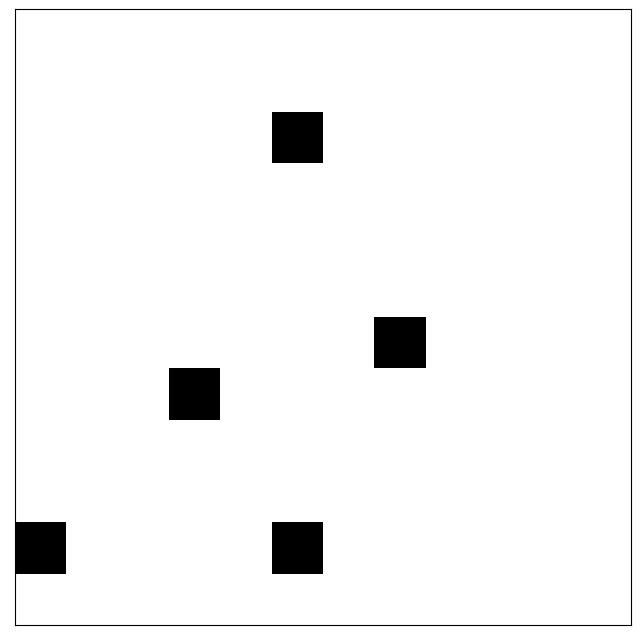

In [76]:
fig, axs = plt.subplots(figsize=(8,8))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=iterations + 1)

In [77]:
anim